In [8]:
# Install dependencies on colab
!pip install -Uqq fastbook

In [9]:
# Connect to google drive to load images and save model
import fastbook
fastbook.setup_book()

In [10]:
from fastai.vision.all import *

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
digits_path = "/content/drive/My Drive/Gestures"

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in a2
- Use `set_seed()` to obtain reproducible results.
- Use `item_tfms` and/or `batch_tfms`. Set `min_scale` so that gestures are still visible
- Use a batch size of 32

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [19]:
set_seed(42)
photos = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=parent_label,
                    item_tfms = Resize(128),
                    batch_tfms=aug_transforms(min_scale=0.5))

photos_dls = photos.dataloaders(digits_path)

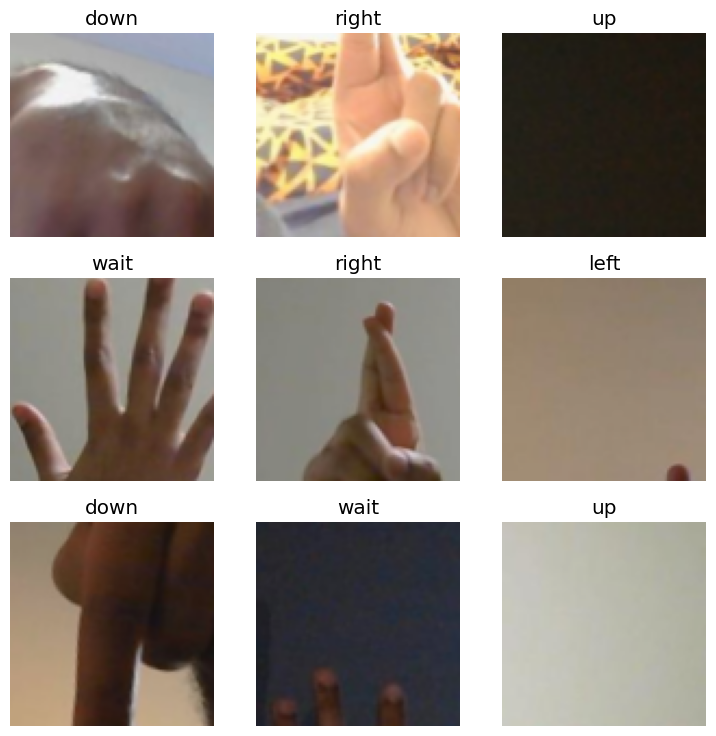

In [20]:
photos_dls.train.show_batch()

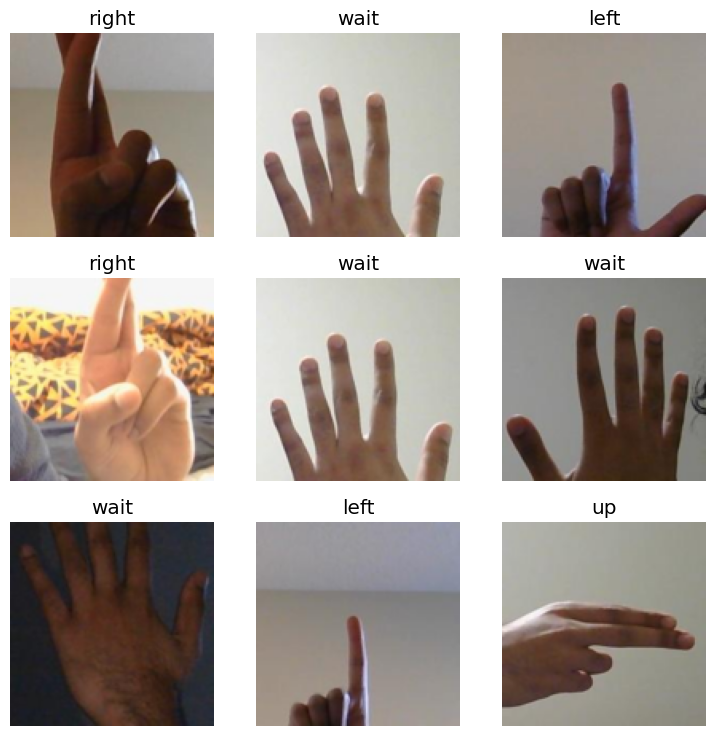

In [21]:
photos_dls.valid.show_batch()

### Question 1: What type of item and batch transforms did you use? Can you spot any problems in the training set augmentations, e.g. gestures not visible?

The item transforms in this program is resize(128) as that works to change the size of the original images to a consistent 128x128 size.The batch transforms used in this DataBlock include aug_transforms(min_scale=0.5), which applies various data augmentations to the images. The min_scale=0.5 parameter ensures that images can be randomly scaled down to 50% of their original size before being cropped back to the target size. The training images that are printed above seem to be cropped in ways that the entire picture isnt being displayed. This is not ideal as the sign is occasionally out of frame.


# 2. Train the classifier

## 2.1 Impact of learning rate
With:
- Same `set_seed()` as above
- Re-creating the same DataLoaders as above
- ResNet18 architecture.
- error rate as metric.

Use three learning rates:
- small: 3e-5
- medium: 3e-3
- large: 1e-1

Train the model with each learning rate using `fine_tune` with 10-15 epochs


In [22]:
learn = vision_learner(photos_dls, arch=resnet18, metrics=error_rate, lr=3e-5)
learn.fine_tune(12)
#Low

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.536403,1.947380,0.607843,00:41


epoch,train_loss,valid_loss,error_rate,time
0,1.440194,0.876233,0.411765,00:01
1,1.115049,0.182236,0.039216,00:01
2,0.949139,0.027541,0.000000,00:01
3,0.765756,0.005921,0.000000,00:01
4,0.667905,0.001908,0.000000,00:01
5,0.579962,0.000447,0.000000,00:01
6,0.490556,0.000154,0.000000,00:01
7,0.434687,0.000125,0.000000,00:02
8,0.382425,0.000140,0.000000,00:01
9,0.350572,0.000113,0.000000,00:01


In [23]:
learn = vision_learner(photos_dls, arch=resnet18, metrics=error_rate, lr=3e-3)
learn.fine_tune(12)
#medium

epoch,train_loss,valid_loss,error_rate,time
0,2.724239,3.014501,0.725490,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.550686,1.635160,0.509804,00:01
1,1.347848,0.650307,0.254902,00:01
2,1.113884,0.199059,0.078431,00:02
3,0.928744,0.029974,0.000000,00:01
4,0.786655,0.016125,0.000000,00:01
5,0.669721,0.008134,0.000000,00:01
6,0.569077,0.002995,0.000000,00:01
7,0.496417,0.001495,0.000000,00:01
8,0.437769,0.001371,0.000000,00:01
9,0.387102,0.001125,0.000000,00:01


In [24]:
learn = vision_learner(photos_dls, arch=resnet18, metrics=error_rate, lr=1e-1)
learn.fine_tune(12)
#large

epoch,train_loss,valid_loss,error_rate,time
0,2.579051,1.764392,0.529412,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.641751,0.960460,0.372549,00:01
1,1.372097,0.434150,0.176471,00:01
2,1.114998,0.105227,0.000000,00:01
3,0.917166,0.013321,0.000000,00:01
4,0.787091,0.001885,0.000000,00:02
5,0.655730,0.000554,0.000000,00:02
6,0.585756,0.000288,0.000000,00:01
7,0.527757,0.000163,0.000000,00:01
8,0.460709,0.000131,0.000000,00:01
9,0.413895,0.000123,0.000000,00:01


### Question 2: Which training run resulted in the best model? State number of epochs and final error rate values for all learning rates and identify the best model.

The largest learning rate model was the best. All three models ran on the same 12 epoch values. Surprisingly all three of the methods ended with 0.0 error rate at higher epoch values The large learning rate was the best as the error rate was lower overall.


### Question 3: Did any models overfit? Include your reasoning.

The medium learning rate model did seem to overfit a bit at epoch 0. The other two learning rates did not experience any overfitting.


# 3. Analyze model performance
- Retrain the best model from above.
- Plot the confusion matrix.
- Plot 10 top losses

In [31]:
model = vision_learner(photos_dls, arch=resnet18, metrics=error_rate, lr=1e-1)
model.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,2.605629,3.687363,0.705882,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.429986,1.882999,0.509804,00:01
1,1.155446,0.759701,0.274510,00:01
2,1.002217,0.137175,0.039216,00:01
3,0.800118,0.026543,0.000000,00:02
4,0.663045,0.010089,0.000000,00:02
5,0.566037,0.005073,0.000000,00:01
6,0.476800,0.002601,0.000000,00:01
7,0.442269,0.001788,0.000000,00:01
8,0.389704,0.001425,0.000000,00:01
9,0.346864,0.001249,0.000000,00:01


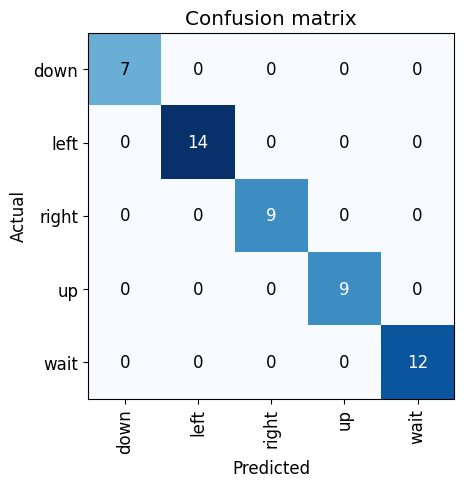

In [32]:
inter = ClassificationInterpretation.from_learner(model)
inter.plot_confusion_matrix()

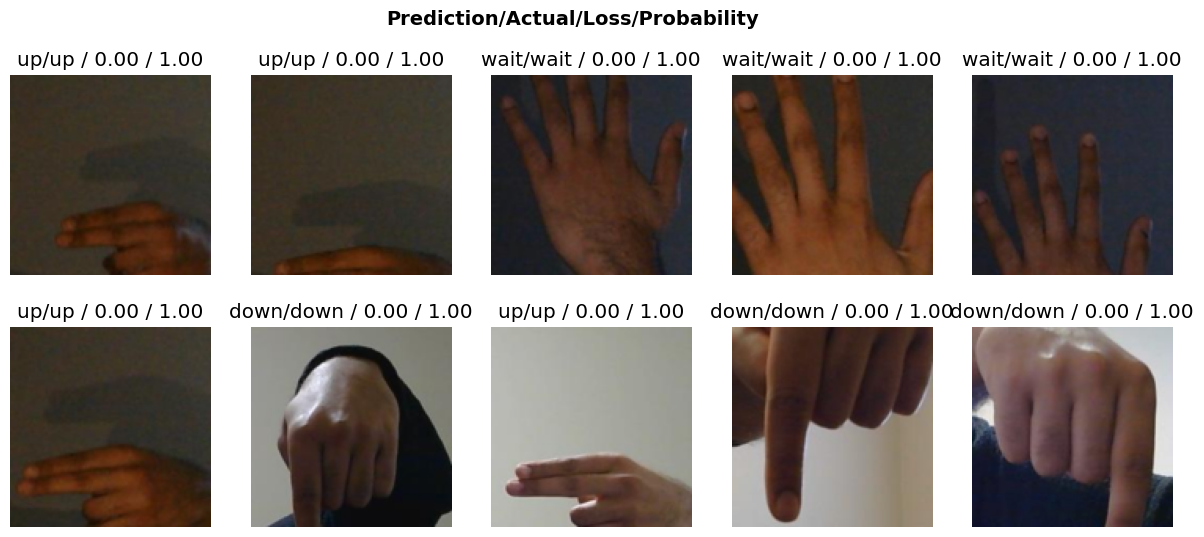

In [27]:
inter.plot_top_losses(10, nrows=2)


### Question 4: With which gestures does your model have the most problems with?

None? The model seems to be getting everything perfectly correct. This is very surprising and I feel as though something in the training must be wrong. Possibly a lack of variety in the images?

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [39]:
export_path = Path("/content/drive/MyDrive/Models")
export_path.mkdir(parents=True, exist_ok=True)
learn.export(fname=export_path/"gesture_model.pkl")

In [40]:
learn.export()
path=Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]

In [41]:
learn_loaded = load_learner(export_path/"gesture_model.pkl")

# 5. Summary and Conclusion

Summarize the best model:
- Training strategy: learning rate and epochs used.
- Error rate achieved, summary of confusion matrix, i.e. what kind of errors does the model make.

The best model was the one with the large learning rate. The error rates were surprisingly low from the beginning and the confusion matrix confirmed that the model was getting every picture 100% correct. I did re-run the model many times and results stayed consistent. I believe the photos that were taken in a2 may have lacked significant variety as bursts were taken with many photos being very similar.

Conclusion:
- Are you satisfied with model performance? Why, why not?

I am satisfied in the sense that it has worked well but am unsure on its integrity due to the lack of error and shockingly high accuracy.


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.
I thought this was a really cool assignment as we were able to follow up on using the images created in a2. I did find it to be a bit unconclusive as the 100% success rate caught me off guard. If I were to do this again I would not use the burst function that was an option in a2 and instead take a greater variety of photos in different environments as the model seems to be working fantastic.
